In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from braindecode.models import ShallowFBCSPNet
import pandas as pd
from collections import OrderedDict

In [3]:
def linear_kernel(X):
    """Computes the linear kernel matrix for X."""
    return X @ X.T  # Dot product

def centering_matrix(K):
    """Centers the kernel matrix K."""
    n = K.shape[0]
    H = np.eye(n,dtype=K.dtype) - (1 / n) * np.ones((n, n), dtype=K.dtype)
    return H # Equivalent to HKH

def compute_hsic(X, Y, kernel_X = linear_kernel, kernel_Y = linear_kernel):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC).
    
    Parameters:
    - X: (n_samples, n_features_X) numpy array
    - Y: (n_samples, n_features_Y) numpy array
    - kernel_X: function to compute the kernel matrix for X
    - kernel_Y: function to compute the kernel matrix for Y
    
    Returns:
    - HSIC value (float)
    """
    X = X.to(torch.float32)
    Y = Y.to(torch.float32)
    
    K = kernel_X(X)
    L = kernel_Y(Y)
    
    K = K.cpu().numpy()
    L = L.cpu().numpy()
    
    H = centering_matrix(K)
   
    
    Kxy_centered = K @ H @ L @ H
    
    hsic_value = np.trace(Kxy_centered) / ((X.shape[0] - 1) ** 2)
    return hsic_value.item()
  
def compute_CKA(X,Y,kernel_X = linear_kernel,kernel_Y = linear_kernel):
  """
  compute CKA between two X,Y activations
  
  Parameters:
  - X: (n_samples, x_features)
  - Y: (n_samples, y_features)
  - kernel_X: kernel for X
  - kernel_Y: kernel for Y  
  """
  HSIC_KL = compute_hsic(X,Y,kernel_X,kernel_Y) 
  HSIC_KK = compute_hsic(X,X,kernel_X,kernel_X)
  HSIC_LL = compute_hsic(Y,Y,kernel_Y, kernel_Y)
  
  return HSIC_KL/(np.sqrt(HSIC_KK * HSIC_LL))


In [4]:
# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = 1125
# Load two models for comparison
model= torch.load("braindecode_model_temponly_1.pth", weights_only=False,map_location=torch.device('cpu'))
model2 = model#ShallowFBCSPNet(in_chans, n_classes, input_window_samples, final_conv_length="auto")



In [5]:
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─SafeLog (pool_nonlin_exp): 1-1         [1, 22, 1125]             [1, 22, 1125]             --                        --
├─Ensure4d (ensuredims): 1-2             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-3            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─Conv2d (conv_time): 1-4                [1, 1, 1125, 22]          [1, 40, 1101, 22]         1,040                     [25, 1]
├─Conv2d (conv_spat): 1-5                [1, 40, 1101, 22]         [1, 40, 1101, 1]          35,200                    [1, 22]
├─BatchNorm2d (bnorm): 1-6               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Ex

In [6]:
def extract_model_activations(model, input_tensor):
    activations = OrderedDict()

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks
    for name, layer in model.named_modules():
        if(name == "conv_time" or name == "conv_spat"):
            layer.register_forward_hook(get_activation(name))


    # Run forward pass AFTER registering hooks
    model.eval()
   
    _ = model(input_tensor)  

    return activations  # Return collected activations

In [8]:
dummy_input = torch.randn(64, in_chans, input_window_samples)

model_1_activations = extract_model_activations(model,dummy_input)
model_2_activations = extract_model_activations(model2,dummy_input)

print(model_1_activations["conv_time"].shape)
print(model_2_activations["conv_spat"].shape)

torch.Size([64, 40, 1101, 22])
torch.Size([64, 40, 1101, 1])


In [ ]:
def visualize_comparison(model_1_activations, model_2_activations):
    # Extract the activation tensors from both models
    act_1 = model_1_activations.get('conv_time_spat')
    act_2 = model_2_activations.get('conv_time_spat')

    if act_1 is not None and act_2 is not None:
        # Average activation across all channels
        avg_act_1 = torch.mean(act_1, dim=1).squeeze(0).cpu().numpy()  # Average across channels (C dimension)
        avg_act_2 = torch.mean(act_2, dim=1).squeeze(0).cpu().numpy()
        

        # Plot side-by-side comparison of average activations
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot for model 1
        axes[0].imshow(avg_act_1, cmap='viridis')
        axes[0].axis('off')
        axes[0].set_title("Model 1 - Average Activation")

        # Plot for model 2
        axes[1].imshow(avg_act_2, cmap='viridis')
        axes[1].axis('off')
        axes[1].set_title("Model 2 - Average Activation")

        plt.tight_layout()
        plt.show()

        # Plot difference between activations (model 1 - model 2)
        activation_diff = avg_act_1 - avg_act_2
        plt.imshow(activation_diff, cmap='seismic', vmin=-np.max(np.abs(activation_diff)), vmax=np.max(np.abs(activation_diff)))
        plt.colorbar()
        plt.axis('off')
        plt.title("Activation Difference (Model 1 - Model 2)")
        plt.show()

    else:
        print("Could not extract activations for 'conv_time_spat'.")

In [ ]:
model_1_activations

OrderedDict([('ensuredims',
              tensor([[[[ 0.0939],
                        [-1.4396],
                        [ 0.7836],
                        ...,
                        [-0.0169],
                        [ 0.0553],
                        [-0.8533]],
              
                       [[ 1.2092],
                        [ 1.1620],
                        [ 0.6780],
                        ...,
                        [ 0.0073],
                        [ 0.1637],
                        [-0.4085]],
              
                       [[ 1.0738],
                        [-0.4787],
                        [ 0.6597],
                        ...,
                        [-1.4695],
                        [-0.3574],
                        [-1.0819]],
              
                       ...,
              
                       [[-0.7820],
                        [ 0.0630],
                        [ 1.1741],
                        ...,
                        [-0.52

In [ ]:
print("Captured Activations for Model 1:")
for layer_name, activation in model_1_activations.items():

    print(f"{layer_name}: {activation.shape}")
    #print(activation)

Captured Activations for Model 1:
ensuredims: torch.Size([64, 22, 1125, 1])
dimshuffle: torch.Size([64, 1, 1125, 22])
conv_time_spat: torch.Size([64, 40, 1101, 1])
bnorm: torch.Size([64, 40, 1101, 1])
conv_nonlin_exp: torch.Size([64, 40, 1101, 1])
pool: torch.Size([64, 40, 69, 1])
pool_nonlin_exp: torch.Size([64, 40, 69, 1])
drop: torch.Size([64, 40, 69, 1])
final_layer.conv_classifier: torch.Size([64, 4, 1, 1])
final_layer.logsoftmax: torch.Size([64, 4, 1, 1])
final_layer.squeeze: torch.Size([64, 4])
final_layer: torch.Size([64, 4])
: torch.Size([64, 4])


In [ ]:
print("Captured Activations for Model 2:")
for layer_name, activation in model_2_activations.items():
    if layer_name == "conv_time_spat":
        print(f"{layer_name}: {activation.shape}")
        print(activation)

Captured Activations for Model 2:
conv_time_spat: torch.Size([64, 40, 1101, 1])
tensor([[[[-4.3084e-01],
          [-2.9341e-01],
          [-2.9189e-02],
          ...,
          [-8.5479e-01],
          [-3.4237e-01],
          [ 7.0780e-01]],

         [[-5.0917e-01],
          [-3.0136e-01],
          [-2.0143e-01],
          ...,
          [-2.0797e-01],
          [-3.6624e-01],
          [ 3.0300e-01]],

         [[ 1.8801e-01],
          [-3.4125e-01],
          [-4.7211e-01],
          ...,
          [-1.9149e-01],
          [-2.3099e-01],
          [-5.4837e-01]],

         ...,

         [[ 7.4832e-01],
          [ 1.1125e+00],
          [ 1.4550e-01],
          ...,
          [ 7.1635e-01],
          [ 1.0869e-01],
          [ 4.7637e-01]],

         [[ 1.0477e-01],
          [ 1.2924e-01],
          [-2.9883e-01],
          ...,
          [-5.2761e-01],
          [-5.1897e-02],
          [ 6.0678e-01]],

         [[-1.0011e+00],
          [-9.5490e-01],
          [-9.2973e-

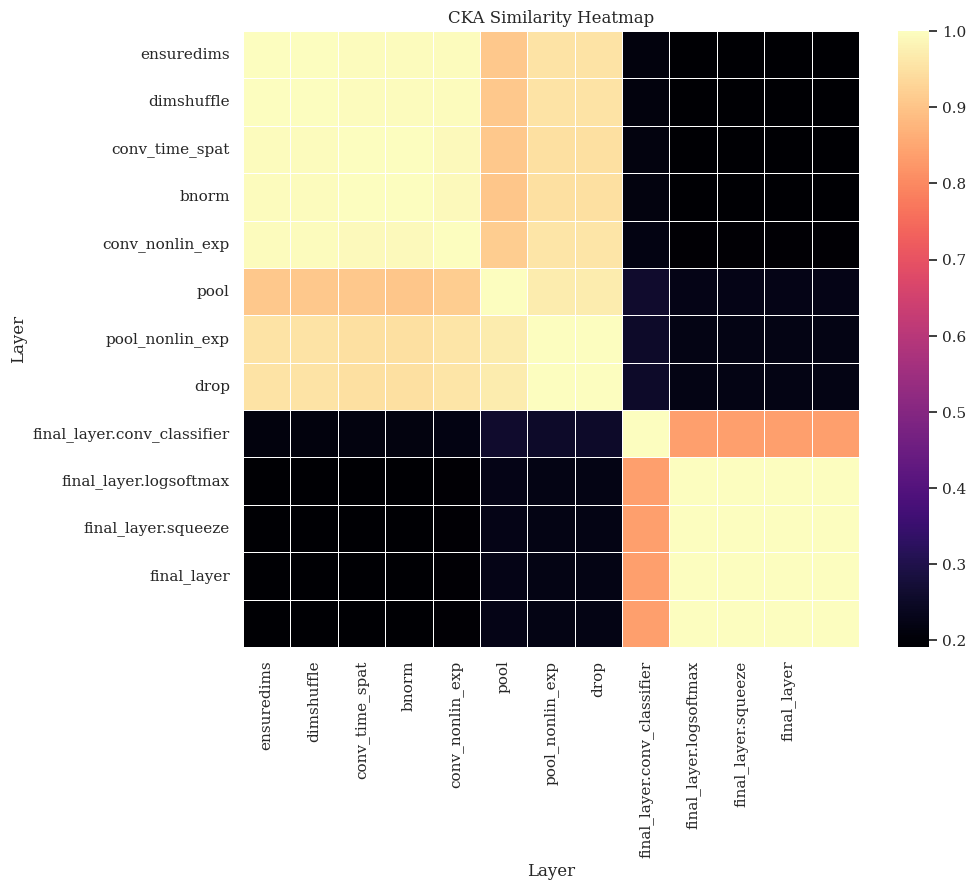

In [ ]:
# Use OrderedDict to preserve the order of layer names
layer_names_model1 = list(model_1_activations.keys())
layer_names_model2 = list(model_2_activations.keys())

cka_similarities = OrderedDict()

# Compute CKA for each layer from model1 and model2
for layer1 in layer_names_model1:
    for layer2 in layer_names_model2:
        activations_x = model_1_activations[layer1].reshape(model_1_activations[layer1].shape[0], -1)
        activations_y = model_2_activations[layer2].reshape(model_2_activations[layer2].shape[0], -1)
        cka_score = compute_CKA(activations_x, activations_y)
        
        cka_similarities[(layer1, layer2)] = cka_score

layer_names = list(OrderedDict.fromkeys(layer_names_model1 + layer_names_model2))

# Initialize a square matrix for the CKA similarities
n_layers = len(layer_names)

matrix = np.zeros((n_layers, n_layers))

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_similarities.items():
    i = layer_names.index(layer1)
    j = layer_names.index(layer2)
    matrix[i, j] = similarity
    matrix[j, i] = similarity 

# Create a DataFrame for better visualization
df = pd.DataFrame(matrix, index=layer_names, columns=layer_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='magma', fmt='.2f', square=True, linewidths=0.5, cbar=True)
plt.title('CKA Similarity Heatmap')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.show()
